## Data Cleaning and Shape Examining 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

training_data = pd.read_csv("../input/train.csv", encoding="ISO-8859-1")
testing_data = pd.read_csv("../input/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('../input/attributes.csv')
descriptions = pd.read_csv('../input/product_descriptions.csv')

training_data = pd.merge(training_data, descriptions, 
                         on="product_uid", how="left")



In [ ]:
training_data.shape

As in the dataset page has mentioned that it might contains some embedded html tags, let's plot and see how many in percentage, more prececily the fields 'product_description'

In [ ]:
%matplotlib inline
total_length = len(descriptions['product_description'] )
has_tag = sum([1 for _ in descriptions['product_description'] if '<br' in _])
no_tags = total_length - has_tag

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(x=[has_tag])
ax.ticklabel_format(useOffset=False)
_ = plt.xlabel('number of phrase which has html tags in')

plt.show()
print('has html tags in ',has_tag)
print('doesn\'t have html tags in ', no_tags)


Now let's see what is the frequency of search query which include digits in it with respect to product_title which 
includes words. As you can see most of them includes digits in search bar. 


In [ ]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search therms
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of digits in search terms
# (training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of digits in title






In [ ]:
(training_data.product_title.str.count("\\w+") + 1).hist(bins=30)#plot number of words in title
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30) #plot number of words in search query





In [ ]:
(training_data.product_title.str.count("\\d+") + 1).hist(bins=30)#plot number of words in title
(training_data.search_term.str.count("\\d+") + 1).hist(bins=30) #plot number of words in search query






In [ ]:
(training_data.product_description.str.count("\\d+") + 1).hist(bins=30)
(training_data.product_description.str.count("\\d+\W+\d+") + 1).hist(bins=30)



let's plot at histogram following number of words in search query, and on the other hand relevancy score

In [ ]:
(training_data.search_term.str.count("\\w+") + 1).hist(bins=30)
(training_data.relevance + 1).hist(bins=30)



let's take a look how does the persistence of digits in the search query influence the relevancy score, from below plot it clearly that most of the search query must have between 2.0 and 3.0 

In [ ]:
(training_data.search_term.str.count("\\d+")).hist(bins=30)
(training_data.relevance ).hist(bins=30)

let’s assume that there are zero response for null query search term


In [ ]:
training_data[training_data.search_term.str.count('\\w+') < 1]
# training_data[training_data.search_term.str.contains('^\d+') < 1]

In [ ]:
# an interest case can be see below, unfortunattly we cannot get rid of this element since it will make a bad impact on model
training_data[training_data.product_uid==100030]

In [ ]:
training_data[training_data.product_description.str.contains('.* x .*')].head(4) # at first it looks like nothing unsual 


Unfortunately, it is kind ambiguous to figure out the meaning of digits in the search context like an example below, it can mean anything. we should take care of this when cleaning context. It looks that most of the case the meaning of X is denoted the unit of measure like fit/inch/or something by something


In [ ]:
# training_data[training_data.search_term.str.contains("^\\d+ . \\d+$")].head(4)
training_data[(training_data.search_term.str.contains("^\\d+ . \\d+$") )& (training_data.relevance > 2)].head(4)

In [ ]:
# exception_number = training_data[training_data.search_term.str.contains("^\\d+ . \\d+$") ]['search_term'].values
# training_data['test'] = training_data[training_data.search_term.str.contains("^\\d+ . \\d+$") ]['search_term'].str.split(' ').values
# training_data[['product_title', 'product_description', 'relevance', ]].corr()
training_data.head(10)

In order to apply any standard method for analysis we have to standardize metric for text fields, which we define as follows

- split into tokens by white space
- remove punctuation from each token
- remove remaining tokens that are not alphabetic
- filter out stop words
- filter out short tokens

and lets also create new feature in the same time which will denote our hypothesis.

\begin{equation*}
H_1 = \{\ \frac{ card(search query)}{ card(product title)} = high\ relevance\ score\} \\
H_2 = \{ length(search query)\ influence\ relevance\ score \} \\
H_3 = \{ card(common\_words(search\ query,product\ title,product\ description)) = influence\ relevance\ score \} \\
\end{equation*}

In [ ]:
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
import nltk



def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    whole_set = set(str1.split())
    return sum(int(str2.find(word)>=0) for word in whole_set)

 



Now let's build feature accordingly to 
\begin{equation*}
H_1, H_2, H_3\\
\end{equation*}

In [ ]:
num_train = training_data.shape[0]
############### cleaning html tags ##################
has_tag_in = training_data.product_description.str.contains('<br')
training_data.loc[has_tag_in, 'product_description'] = training_data.loc[has_tag_in, 'product_description'].map(lambda x:remove_html_tag(x))
###############

############## apply stemming #####################
training_data['search_term'] = training_data['search_term'].map(lambda x:str_stemmer_title(x))
training_data['product_title'] = training_data['product_title'].map(lambda x:str_stemmer(x))

training_data['product_description'] = training_data['product_description'].map(lambda x:str_stemmer(x))
############## end stemming #####################

############## building custome feature, let's build a few of them before compare which one is the best ###########
training_data['len_of_query'] = training_data['search_term'].map(lambda x:len(x.split())).astype(np.int64)
training_data['shared_words'] = training_data[['search_term','product_description', 'product_title']].apply(lambda row:sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1)

# training_data['frequency_digits_in_sq']=training_data.product_description.str.count("\\d+")
training_data['frequency_words_in_sq'] = training_data.product_description.str.count("\\w+")
training_data["distance"] = training_data.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1)


In [ ]:
#let's take a look if there is not empty search query now
# empty_search_query = training_data[training_data.search_term.str.count('\\w+') < 1].values
# print('data frame of empty seach query along with products',empty_search_query)
# # training_data[training_data.product_uid==100030]
# is_anything_none = training_data.isnull().values.any()
# print('presence of Nan values',  is_anything_none)


# training_data
training_data.corr()


In [ ]:
training_data[training_data.search_term.str.match("\\d+ x \\d+") > 0]

In [ ]:
#lets create new feature which will denote 
training_data['test'] = training_data[['shared_words', 'frequency_words_in_sq']].apply(lambda row:row[1]+row[0],axis=1)


In [ ]:
# training_data[['product_title','len_of_query','shared_words','frequency_words_in_sq','relevance', 'test']].corr()
training_data[['product_title','len_of_query','shared_words','frequency_words_in_sq','relevance', 'test']].corr()´

In [ ]:
# %matplotlib inline
# r = training_data[training_data.search_term.str.contains('^\d+\s+?\w\s+?\d+$')]
# (r.relevance ).hist(bins=30)
# r.describe()
training_data.head(3)

In [ ]:
df_all = training_data.drop(['search_term','product_description','product_title','test'],axis=1)

In [ ]:
df_train = df_all.iloc[:num_train]
df_test = df_all.iloc[num_train:]
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values


In [ ]:
df_train.head(3)

In [ ]:
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)


Analysis of the Model


In [1]:
from nltk.metrics import edit_distance
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


df_train = pd.read_csv("../input/train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("../input/test.csv", encoding="ISO-8859-1")
attribute_data = pd.read_csv('../input/attributes.csv')
df_pro_desc = pd.read_csv('../input/product_descriptions.csv')



df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

num_train = df_train.shape[0]

###############
from bs4 import BeautifulSoup
import lxml
import re
import nltk
from nltk.corpus import stopwords # Import the stop word list
from nltk.metrics import edit_distance
from string import punctuation
from collections import Counter
import nltk



def remove_html_tag(text):
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text().replace('Click here to review our return policy for additional information regarding returns', '')
    return text

def str_stemmer(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def str_stemmer_title(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    whole_set = set(str1.split())
    return sum(int(str2.find(word)>=0) for word in whole_set)

 




###############
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')


############## apply stemming #####################
df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer_title(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))

df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))
############## end stemming #####################

############## building custome feature, let's build a few of them before compare which one is the best ###########
df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)
df_all['shared_words'] = df_all[['search_term','product_description', 'product_title']].apply(lambda row:sum([str_common_word(*row[:-1]), str_common_word(*row[1:])]), axis=1).astype(np.int64)

# training_data['frequency_digits_in_sq']=training_data.product_description.str.count("\\d+")
df_all['frequency_words_in_sq'] = df_all.product_description.str.count("\\w+").astype(np.int64)
df_all["distance_levistein"] = df_all.loc[:, ["search_term","product_title"]].apply(lambda x: edit_distance(*x), axis=1).astype(np.int64)

df_all['length in product info'] = training_data[['product_title','product_description']].apply(lambda row:sum([len(*row[:-1]), len(*row[1:])]), axis=1).astype(np.int64)

df_all = df_all.drop(['search_term','product_title','product_description'],axis=1)


df_train = df_all.iloc[:num_train]
print('df_train',df_train)
df_test = df_all.iloc[num_train:]
print('df_test',df_test)
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

#### Feature to the same scale
scX = StandardScaler()
X_train = scX.fit_transform(X_train)
X_test = scX.fit_transform(X_test)

rf = RandomForestRegressor(n_estimators=4, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

FileNotFoundError: File b'../input/train.csv' does not exist

In [ ]:
training_data[training_data.search_term.str.count('\\w+')<1]

In [1]:
from nltk.metrics import edit_distance
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


df_train = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
df_test = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
df_pro_desc = pd.read_csv('input/product_descriptions.csv.zip')



df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

num_train = df_train.shape[0]

def str_stemmer(s):
    return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
    return sum(int(str2.find(word)>=0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')




/Users/iurii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/iurii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [2]:
df_all

,id,product_title,product_uid,relevance,search_term,product_description
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...
5,18,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,convection otr,Achieving delicious results is almost effortle...
6,20,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,2.67,microwave over stove,Achieving delicious results is almost effortle...
7,21,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,microwaves,Achieving delicious results is almost effortle...
8,23,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,2.67,emergency light,The Quantum Adjustable 2-Light LED Black Emerg...
9,27,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,3.00,mdf 3/4,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...


In [3]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
 
def sentence_similarity(sent1, sent2, stopwords=None):
    sent1 = sent1.split(' ')
    sent2 = sent2.split(' ')
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [4]:
df_all["text_rank_sp"] = df_all.loc[:, ["search_term","product_title"]].apply(lambda x: sentence_similarity(*x), axis=1)


In [5]:
df_all.corr() # it deserve attention since till now the only correlation I've got was .0x. It shows that it is 

,id,product_uid,relevance,text_rank_sp
id,1.000000,0.984194,-0.116426,0.114519
product_uid,0.984194,1.000000,-0.130656,0.108358
relevance,-0.116426,-0.130656,1.000000,0.262935
text_rank_sp,0.114519,0.108358,0.262935,1.000000


In [6]:
df_all.corr()

,id,product_uid,relevance,text_rank_sp
id,1.000000,0.984194,-0.116426,0.114519
product_uid,0.984194,1.000000,-0.130656,0.108358
relevance,-0.116426,-0.130656,1.000000,0.262935
text_rank_sp,0.114519,0.108358,0.262935,1.000000


In [7]:
import re
stop_w = ['for', 'xbi', 'and', 'in', 'th','on','sku','with','what','from','that','less','er','ing'] #'electr','paint','pipe','light','kitchen','wood','outdoor','door','bathroom'
strNum = {'zero':0,'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'nine':9}


def str_stem(s): 
    if isinstance(s, str):
        s = re.sub(r"(\w)\.([A-Z])", r"\1 \2", s) #Split words with a.A
        s = s.lower()
        s = s.replace("  "," ")
        s = s.replace(",","") #could be number / segment later
        s = s.replace("$"," ")
        s = s.replace("?"," ")
        s = s.replace("-"," ")
        s = s.replace("//","/")
        s = s.replace("..",".")
        s = s.replace(" / "," ")
        s = s.replace(" \\ "," ")
        s = s.replace("."," . ")
        s = re.sub(r"(^\.|/)", r"", s)
        s = re.sub(r"(\.|/)$", r"", s)
        s = re.sub(r"([0-9])([a-z])", r"\1 \2", s)
        s = re.sub(r"([a-z])([0-9])", r"\1 \2", s)
        s = s.replace(" x "," xbi ")
        s = re.sub(r"([a-z])( *)\.( *)([a-z])", r"\1 \4", s)
        s = re.sub(r"([a-z])( *)/( *)([a-z])", r"\1 \4", s)
        s = s.replace("*"," xbi ")
        s = s.replace(" by "," xbi ")
        s = re.sub(r"([0-9])( *)\.( *)([0-9])", r"\1.\4", s)
        s = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", s)
        s = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", s)
        s = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", s)
        s = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", s)
        s = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", s)
        s = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", s)
        s = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", s)
        s = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", s)
        s = s.replace("°"," degrees ")
        s = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", s)
        s = s.replace(" v "," volts ")
        s = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", s)
        s = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", s)
        s = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", s)
        s = s.replace("  "," ")
        s = s.replace(" . "," ")
        #s = (" ").join([z for z in s.split(" ") if z not in stop_w])
        s = (" ").join([str(strNum[z]) if z in strNum else z for z in s.split(" ")])
        s = (" ").join([stemmer.stem(z) for z in s.split(" ")])
        
        s = s.lower()
        s = s.replace("toliet","toilet")
        s = s.replace("airconditioner","air conditioner")
        s = s.replace("vinal","vinyl")
        s = s.replace("vynal","vinyl")
        s = s.replace("skill","skil")
        s = s.replace("snowbl","snow bl")
        s = s.replace("plexigla","plexi gla")
        s = s.replace("rustoleum","rust-oleum")
        s = s.replace("whirpool","whirlpool")
        s = s.replace("whirlpoolga", "whirlpool ga")
        s = s.replace("whirlpoolstainless","whirlpool stainless")
        return s
    else:
        return "null"
    
def seg_words(str1, str2):
    str2 = str2.lower()
    str2 = re.sub("[^a-z0-9./]"," ", str2)
    str2 = [z for z in set(str2.split()) if len(z)>2]
    words = str1.lower().split(" ")
    s = []
    for word in words:
        if len(word)>3:
            s1 = []
            s1 += segmentit(word,str2,True)
            if len(s)>1:
                s += [z for z in s1 if z not in ['er','ing','s','less'] and len(z)>1]
            else:
                s.append(word)
        else:
            s.append(word)
    return (" ".join(s))

def segmentit(s, txt_arr, t):
    st = s
    r = []
    for j in range(len(s)):
        for word in txt_arr:
            if word == s[:-j]:
                r.append(s[:-j])
                #print(s[:-j],s[len(s)-j:])
                s=s[len(s)-j:]
                r += segmentit(s, txt_arr, False)
    if t:
        i = len(("").join(r))
        if not i==len(st):
            r.append(st[i:])
    return r


In [8]:
# df_all['search_term'] = df_all['search_term'].map(lambda x:str_stem(x))
# df_all['product_title'] = df_all['product_title'].map(lambda x:str_stem(x))

# df_all['product_description'] = df_all['product_description'].map(lambda x:str_stem(x))
df_all['search_term'] = df_all['search_term'].apply(lambda x:str_stem(x))
df_all['product_title'] = df_all['product_title'].apply(lambda x:str_stem(x))

df_all['product_description'] = df_all['product_description'].apply(lambda x:str_stem(x))

In [9]:
df_all.corr()

,id,product_uid,relevance,text_rank_sp
id,1.000000,0.984194,-0.116426,0.114519
product_uid,0.984194,1.000000,-0.130656,0.108358
relevance,-0.116426,-0.130656,1.000000,0.262935
text_rank_sp,0.114519,0.108358,0.262935,1.000000


In [10]:
df_all["text_rank_sp"] = df_all.loc[:, ["search_term","product_title"]].apply(lambda x: sentence_similarity(*x), axis=1)
df_all["text_rank_sd"] = df_all.loc[:, ["search_term","product_description"]].apply(lambda x: sentence_similarity(*x), axis=1)
df_all["text_rank_overall"] = df_all.loc[:, ["text_rank_sp","text_rank_sd"]].apply(lambda x: sum(*x), axis=1)



df_all.corr()

,id,product_uid,relevance,text_rank_sp
id,1.000000,0.984194,-0.116426,0.123285
product_uid,0.984194,1.000000,-0.130656,0.116812
relevance,-0.116426,-0.130656,1.000000,0.326012
text_rank_sp,0.123285,0.116812,0.326012,1.000000


KeyError: "None of [['search_term', 'product_description']] are in the [columns]"

In [11]:
df_all[df_all.search_term.str.count('\w+')<1]

,id,product_title,product_uid,relevance,search_term,product_description,text_rank_sp


In [12]:
df_all = df_all.drop(['search_term','product_title','product_description'],axis=1)


df_train = df_all.iloc[:num_train]
print('df_train',df_train)
df_test = df_all.iloc[num_train:]
print('df_test',df_test)
id_test = df_test['id']

y_train = df_train['relevance'].values
X_train = df_train.drop(['id','relevance'],axis=1).values
X_test = df_test.drop(['id','relevance'],axis=1).values

#### Feature to the same scale
scX = StandardScaler()
X_train = scX.fit_transform(X_train)
X_test = scX.fit_transform(X_test)

rf = RandomForestRegressor(n_estimators=4, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=4, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission.csv',index=False)

df_train            id  product_uid  relevance  text_rank_sp
0           2       100001       3.00      0.288675
1           3       100001       2.50      0.000000
2           9       100002       3.00      0.000000
3          16       100005       2.33      0.154303
4          17       100005       2.67      0.462910
5          18       100006       3.00      0.196116
6          20       100006       2.67      0.320256
7          21       100006       3.00      0.277350
8          23       100007       2.67      0.612372
9          27       100009       3.00      0.196116
10         34       100010       2.67      0.267261
11         35       100011       3.00      0.433861
12         37       100011       3.00      0.171499
13         38       100011       2.00      0.171499
14         48       100012       2.67      0.327327
15         51       100013       2.67      0.316228
16         65       100016       3.00      0.353553
17         69       100017       1.00      0.000000
18 

In [ ]:
training_data.corr()

In [14]:
%matplot
df_all.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b73dcf8>,
      dtype=object)

<bound method RegressorMixin.score of BaggingRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=4, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.1, n_estimators=4, n_jobs=None, oob_score=False,
         random_state=25, verbose=0, warm_start=False)>

OWN approach

pipeline=['remove punctiation', 'tokenization','stemming']

In [8]:
import string
import re
import nltk


ps = nltk.stem.PorterStemmer()
wn = nltk.WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')

def remove_punctuation(text):
    txt = ''.join(character for character in text if character not in string.punctuation)
    return txt

def tokenization(text, stopwords = None):
    tokens = re.split('\W+', text)
    if stopwords:
        tokens = [token for token in tokens if token not in stopwords]
    return tokens
        
    
def stemming(tokens):
    new_tokens = list(map(ps.stem, tokens))
#     new_tokens = [ps.stem(token) for token in tokens]
    return new_tokens

def lemmatizing(tokens):
    new_tokens = list(map(wn.lemmatize, tokens))
    return new_tokens

def result(txt):
    txt1 = remove_punctuation(txt)
    txt1 = tokenization(txt1)
    txt1 = stemming(txt1)
    return txt1
# _____________




In [5]:
# stemming(['quick','quicking','quicker'])
result("quick quicking quicker...")

['quick', 'quick', 'quicker']

In [6]:
from nltk.metrics import edit_distance
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


df_train = pd.read_csv("input/train.csv.zip", encoding="ISO-8859-1")
df_test = pd.read_csv("input/test.csv.zip", encoding="ISO-8859-1")
attribute_data = pd.read_csv('input/attributes.csv.zip')
df_pro_desc = pd.read_csv('input/product_descriptions.csv.zip')



df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

num_train = df_train.shape[0]


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')





/Users/iurii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/iurii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [7]:
df_all['search_term_tokens'] = df_all['search_term'].apply(lambda row:result(row))
df_all['product_description_tokens'] = df_all['product_description'].apply(lambda row:result(row))

In [9]:
df_all

,id,product_title,product_uid,relevance,search_term,product_description,search_term_tokens,product_description_tokens
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...","[angl, bracket]","[not, onli, do, angl, make, joint, stronger, t..."
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...","[l, bracket]","[not, onli, do, angl, make, joint, stronger, t..."
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,"[deck, over]","[behr, premium, textur, deckov, is, an, innov,..."
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,"[rain, shower, head]","[updat, your, bathroom, with, the, delta, vero..."
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,"[shower, onli, faucet]","[updat, your, bathroom, with, the, delta, vero..."
5,18,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,convection otr,Achieving delicious results is almost effortle...,"[convect, otr]","[achiev, delici, result, is, almost, effortles..."
6,20,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,2.67,microwave over stove,Achieving delicious results is almost effortle...,"[microwav, over, stove]","[achiev, delici, result, is, almost, effortles..."
7,21,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,microwaves,Achieving delicious results is almost effortle...,[microwav],"[achiev, delici, result, is, almost, effortles..."
8,23,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,2.67,emergency light,The Quantum Adjustable 2-Light LED Black Emerg...,"[emerg, light]","[the, quantum, adjust, 2light, led, black, eme..."
9,27,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,3.00,mdf 3/4,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,"[mdf, 34]","[get, the, hous, of, fara, 34, in, x, 3, in, x..."


In [15]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [20]:
# df_all['product_description_sim'] = df_all['product_description'].apply(lambda row:result(row))
df_all["text_rank_overall"] = df_all.loc[:, ["search_term_tokens","product_description_tokens"]].apply(lambda x: sentence_similarity(*x), axis=1)



In [21]:
df_all.corr()

,id,product_uid,relevance,text_rank_overall
id,1.000000,0.984194,-0.116426,0.014019
product_uid,0.984194,1.000000,-0.130656,0.009961
relevance,-0.116426,-0.130656,1.000000,0.198089
text_rank_overall,0.014019,0.009961,0.198089,1.000000


In [22]:
df_all.head(10)

,id,product_title,product_uid,relevance,search_term,product_description,search_term_tokens,product_description_tokens,text_rank_overall
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3.00,angle bracket,"Not only do angles make joints stronger, they ...","[angl, bracket]","[not, onli, do, angl, make, joint, stronger, t...",0.138380
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.50,l bracket,"Not only do angles make joints stronger, they ...","[l, bracket]","[not, onli, do, angl, make, joint, stronger, t...",0.000000
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3.00,deck over,BEHR Premium Textured DECKOVER is an innovativ...,"[deck, over]","[behr, premium, textur, deckov, is, an, innov,...",0.109545
3,16,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.33,rain shower head,Update your bathroom with the Delta Vero Singl...,"[rain, shower, head]","[updat, your, bathroom, with, the, delta, vero...",0.040226
4,17,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,100005,2.67,shower only faucet,Update your bathroom with the Delta Vero Singl...,"[shower, onli, faucet]","[updat, your, bathroom, with, the, delta, vero...",0.120678
5,18,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,convection otr,Achieving delicious results is almost effortle...,"[convect, otr]","[achiev, delici, result, is, almost, effortles...",0.053712
6,20,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,2.67,microwave over stove,Achieving delicious results is almost effortle...,"[microwav, over, stove]","[achiev, delici, result, is, almost, effortles...",0.054819
7,21,Whirlpool 1.9 cu. ft. Over the Range Convectio...,100006,3.00,microwaves,Achieving delicious results is almost effortle...,[microwav],"[achiev, delici, result, is, almost, effortles...",0.075960
8,23,Lithonia Lighting Quantum 2-Light Black LED Em...,100007,2.67,emergency light,The Quantum Adjustable 2-Light LED Black Emerg...,"[emerg, light]","[the, quantum, adjust, 2light, led, black, eme...",0.214373
9,27,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,100009,3.00,mdf 3/4,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,"[mdf, 34]","[get, the, hous, of, fara, 34, in, x, 3, in, x...",0.111111


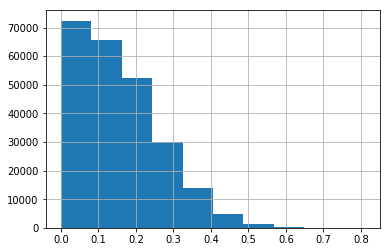

In [24]:
%matplotlib inline
df_all.text_rank_overall.hist()

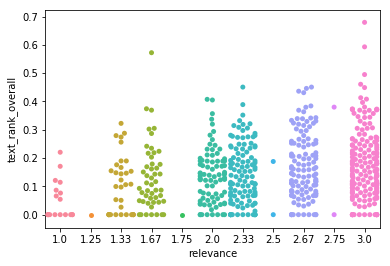

In [28]:
import seaborn as sns
sns.swarmplot(x='relevance',y='text_rank_overall', data=df_all[:600])

In [ ]:
df